# Download Zip And unzip

In [7]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!gdown --id '1XgnBPc4fG412-4HCFl-o9uBJO9PS58HK'

Downloading...
From: https://drive.google.com/uc?id=1XgnBPc4fG412-4HCFl-o9uBJO9PS58HK
To: /content/CSE4238_Soft_Computing_Assignment_2_Dataset_2.zip
69.8MB [00:02, 25.2MB/s]


In [4]:
!unzip '/content/CSE4238_Soft_Computing_Assignment_2_Dataset_2.zip'

Archive:  /content/CSE4238_Soft_Computing_Assignment_2_Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


## Data

In [12]:
train_df = pd.read_csv('/content/Dataset_2/verification_train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 60000
Number of training pixels: 784
Number of classes: 10


In [14]:
test_df = pd.read_csv('/content/Dataset_2/verification_test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)-1
n_class = len(set(train_df['label']))

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of train samples: 10000
Number of test pixels: 784
Number of classes: 10


In [ ]:
'''
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')
'''

# Data Preprocess

In [16]:
class processDataset(Dataset):
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        # training data
        self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
        self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.transform(self.X[idx]), self.y[idx]

In [17]:
train_dataset = processDataset('/content/Dataset_2/verification_train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = processDataset('/content/Dataset_2/verification_test.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.5,), std=(0.5,))]))

In [18]:
print(len(train_dataset), len(test_dataset))

60000 10000


# Models

## Model 1

In [20]:
# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28
output_dim = 10
learning_rate = 0.01

In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 75)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(75, 45)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(45, 30)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(30, 20)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(20, 16)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(16, 14)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(14, num_classes)

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)
                labels = labels.to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                loss = criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              print('***Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_01_dataset_2.pt')
              test_loss_min = test_loss

Iteration: 500. Train_Loss: 0.3846165653069814. Valid_Loss: 2.303398145198822. Accuracy: 10.0
***Validation loss decreased (9999999.000000 --> 2.303398). Saving model ...***
Iteration: 1000. Train_Loss: 0.3836836180639201. Valid_Loss: 2.300647465039587. Accuracy: 18.67
***Validation loss decreased (2.303398 --> 2.300647). Saving model ...***
Iteration: 1500. Train_Loss: 0.38311355426205784. Valid_Loss: 2.2970164221493055. Accuracy: 21.66
***Validation loss decreased (2.300647 --> 2.297016). Saving model ...***
Iteration: 2000. Train_Loss: 0.3821966124165579. Valid_Loss: 2.2870560537616607. Accuracy: 20.82
***Validation loss decreased (2.297016 --> 2.287056). Saving model ...***
Iteration: 2500. Train_Loss: 0.37904046952239767. Valid_Loss: 2.2554230177010184. Accuracy: 32.63
***Validation loss decreased (2.287056 --> 2.255423). Saving model ...***
Iteration: 3000. Train_Loss: 0.36491503656290963. Valid_Loss: 2.046073272938367. Accuracy: 32.45
***Validation loss decreased (2.255423 --> 2

## Loss Graph

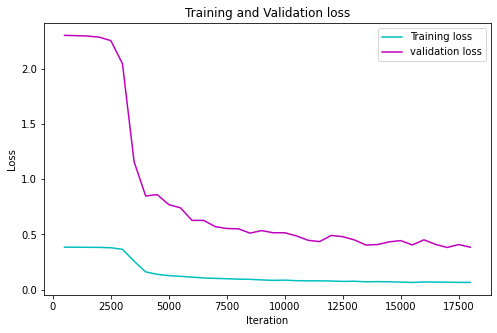

In [24]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(iter_data, train_loss_data, 'c', label='Training loss')
plt.plot(iter_data, test_loss_data, 'm', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

##  Accuract Graph 

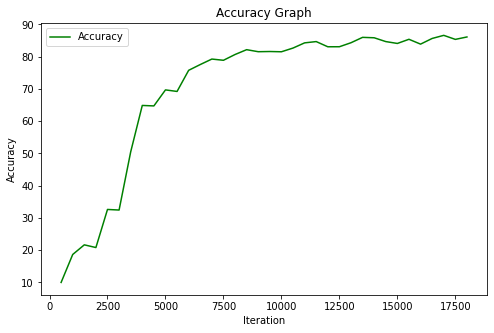

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(iter_data, acc_data, 'g', label='Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model 2

In [26]:
# Hyperparameters
batch_size = 64
num_iters = 40000
input_dim = 28*28
output_dim = 10
learning_rate = 0.01


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 684)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(684, 500)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(500, 300)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(300, 150)
        self.relu_4 = nn.ReLU()

        self.linear_out = nn.Linear(150, num_classes)
        self.relu_out = nn.ReLU()

    def forward(self, x):
        
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)
        
        probas  = self.linear_out(out)
        probas  = self.relu_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


iter = 0
test_loss_min = 9999999
iter_data,train_loss_data, test_loss_data, acc_data = [], [], [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        
        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, input_dim).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)
                test_loss += loss.item() * images.size(0)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            train_loss = train_loss / len(train_loader.dataset)
            test_loss = test_loss / len(test_loader.dataset)
            train_loss_data.append(train_loss)
            test_loss_data.append(test_loss)
            accuracy = 100 * correct.item() / total
            acc_data.append(accuracy)
            iter_data.append(iter)

            # Print Loss
            print('Iteration: {}. Train_Loss: {}. Valid_Loss: {}. Accuracy: {}'.format(iter, train_loss, test_loss, accuracy))

            if test_loss <= test_loss_min:
              print('***Validation loss decreased ({:.4f} --> {:.4f}). Saving model ...***'.format(test_loss_min,test_loss))
              torch.save(model.state_dict(), 'EXP_02_trial_2.pt')
              test_loss_min = test_loss

Iteration: 500. Train_Loss: 1.87353191019694. Valid_Loss: 2.774081230163574. Accuracy: 43.67
***Validation loss decreased (9999999.0000 --> 2.7741). Saving model ...***
Iteration: 1000. Train_Loss: 0.16934515012105306. Valid_Loss: 2.845170497894287. Accuracy: 47.25
Iteration: 1500. Train_Loss: 1.3482965290587765. Valid_Loss: 2.276176297903061. Accuracy: 49.43
***Validation loss decreased (2.7741 --> 2.2762). Saving model ...***
Iteration: 2000. Train_Loss: 0.327765043258667. Valid_Loss: 2.517754077911377. Accuracy: 50.49
Iteration: 2500. Train_Loss: 1.3045611861953417. Valid_Loss: 2.8165969902515413. Accuracy: 51.23
Iteration: 3000. Train_Loss: 0.4816157038370768. Valid_Loss: 2.3380250930786133. Accuracy: 51.52
Iteration: 3500. Train_Loss: 1.21459906213551. Valid_Loss: 2.4825700852394106. Accuracy: 60.45
Iteration: 4000. Train_Loss: 0.4346461966196696. Valid_Loss: 1.8339176177978516. Accuracy: 68.97
***Validation loss decreased (2.2762 --> 1.8339). Saving model ...***
Iteration: 4500. 

## Loss Graph

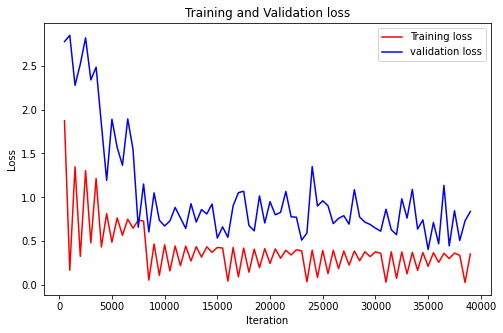

In [30]:
import matplotlib.pyplot as plt
plt.plot(iter_data, train_loss_data, 'r', label='Training loss')
plt.plot(iter_data, test_loss_data, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Accuracy Graph

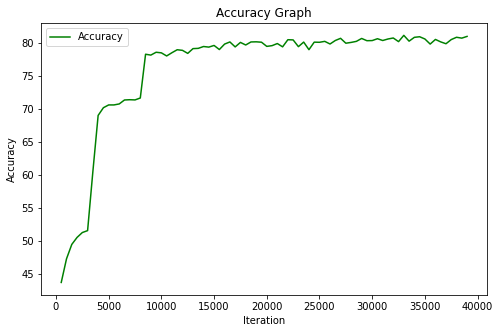

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(iter_data, acc_data, 'g', label='Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()